# 勾配消失および勾配爆発に関するシミュレーション

* RNNレイヤの逆伝播計算では、$dH_{next}^t$を受け取り、$dH_{prev}^t$を出力する。
* $dH_{prev}^t$は、$dH_{prev}^t=df \odot dH_{next}^{t} \cdot W_h^{T}$で計算される。
* $W_h^T$はどの時刻でも同じ値であるため、逆伝播の際、同じ値が何度も掛けられることになる。
* これにより、値が指数関数的に大きくなったり小さくなったりすることがある。
* ここでは、その現象を簡単なシミュレーションによって確認する。  


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# maskの確認
x = np.random.randn(2, 3)
mask = x>0
print(mask)
print(x*mask)

[[False False False]
 [ True  True  True]]
[[-0.         -0.         -0.        ]
 [ 0.90771207  0.66283431  0.08429097]]


In [3]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
    
def time_loop(weight, f):
    """
    Wh : 重み行列
    df : 活性化関数の微分値
    """
    N = 10  # バッチサイズ
    H = 3  # 隠れ状態ベクトルの次元数
    T = 20  # 時系列データの長さ

    # 乱数によって、Whの重みを決める   
    np.random.seed(3)    
    Wh = np.random.randn(H, H)
    if weight=="smaller":    
        Wh *= 0.5
    
    # dhの初期化
    dh = np.ones((N, H))

    if f=="linear":
        df = np.ones((N, H)) #微分
    elif f=="sigmoid":
        np.random.seed(1234)
        x = np.random.randn(N, H)
        y = sigmoid(x)
        df = y*(1-y)  #微分
    elif f=="tanh":
        np.random.seed(1234)
        x = np.random.randn(N, H)
        y = np.tanh(x)
        df = 1- y**2 #微分
    elif f=="relu":
        np.random.seed(1234)
        x = np.random.randn(N, H)
        mask = (x > 0)
        df = mask #微分

    norm_list = []
    for t in range(T):
        dh = df * np.dot(dh, Wh.T) 
        norm = np.sqrt(np.sum(dh**2)) / N # 2ノルムをNで割る。　Nで割ることでデータ数で正規化される
        norm_list.append(norm)

    return norm_list


### 重み$W_h$が何度も掛け合わされることの影響

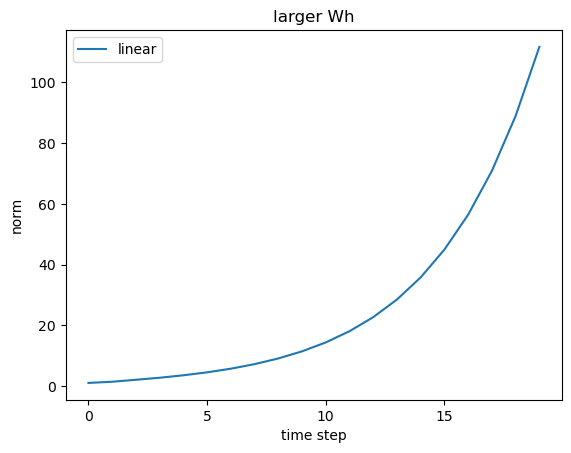

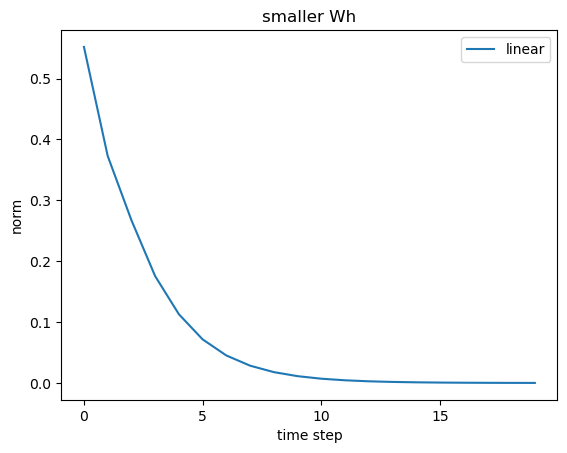

In [4]:
# シミュレーションの実行
for weight in ["larger", "smaller"]:
    li_f = ["linear"]
    for f in li_f:
        norm_list = time_loop(weight, f)

        # グラフの描画
        plt.plot(np.arange(len(norm_list)), norm_list)
        
    plt.xticks(np.arange(0,20,5))
    plt.xlabel('time step')
    plt.ylabel('norm')
    plt.title("%s Wh"%(weight))
    plt.legend(li_f)
    plt.show()


### [まとめ]
* $W_h$が大きい場合、time stepが進むにつれて、勾配が大きくなっていくことがわかる。これは勾配爆発と呼ばれる。
* $W_h$が小さい場合、time stepが進むにつれて、勾配が小さくなっていくことがわかる。これは勾配消失と呼ばれる。

### 活性化関数の違いによる影響

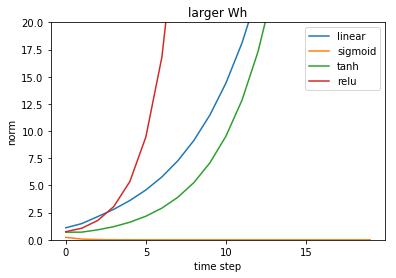

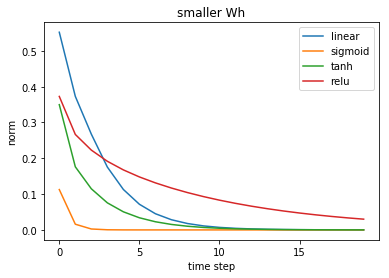

In [5]:
# シミュレーションの実行
for weight in ["larger", "smaller"]:
    li_f = ["linear", "sigmoid", "tanh", "relu"]
    for f in li_f:
        norm_list = time_loop(weight, f)

        # グラフの描画
        plt.plot(np.arange(len(norm_list)), norm_list)
        
    plt.xticks(np.arange(0,20,5))
    plt.xlabel('time step')
    plt.ylabel('norm')
    plt.title("%s Wh"%(weight))
    plt.legend(li_f)
    
    if weight=="larger":
        plt.ylim([0,20])
    plt.show()


### [まとめ]
* $W_h$が大きい場合、勾配爆発の進行が早い活性化関数の順番は、 relu > linear > tanh > sigmoidである。
* $W_h$が小さい場合、勾配消失の進行が早い活性化関数の順番は、 sigmoid > tanh > linear > reluである。
* NやHの条件を変えると結果も変わるため、どの活性化関数が良いとは一概に言えないが、Whの初期値や活性化関数の種類が勾配に与える影響は小さくない。